<a href="https://colab.research.google.com/github/harnalashok/databases/blob/main/Replication_and_Sharding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 17th Feb, 2022

## Replication
See this [link](https://docs.mongodb.com/manual/replication/)

A replica set in MongoDB is a group of mongod processes that maintain the same data set. Replica sets provide redundancy and high availability, and are the basis for all production deployments. In some cases, replication can provide increased read capacity as clients can send read operations to different servers. Maintaining copies of data in different data centers can increase data locality and availability for distributed applications. You can also maintain additional copies for dedicated purposes, such as disaster recovery, reporting, or backup.

A replica set contains several data bearing nodes and optionally one arbiter node. Of the data bearing nodes, one and only one member is deemed the primary node, while the other nodes are deemed secondary nodes.

The primary node receives all write operations. A replica set can have only one primary capable of confirming writes with { w: "majority" } write concern; although in some circumstances, another mongod instance may transiently believe itself to also be primary. The primary records all changes to its data sets in its operation log, called oplog.

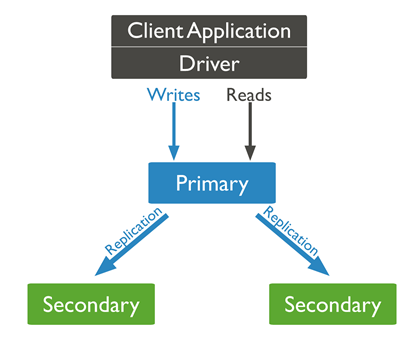

The secondaries replicate the primary's oplog and apply the operations to their data sets such that the secondaries' data sets reflect the primary's data set. If the primary is unavailable, an eligible secondary will hold an election to elect itself the new primary. 

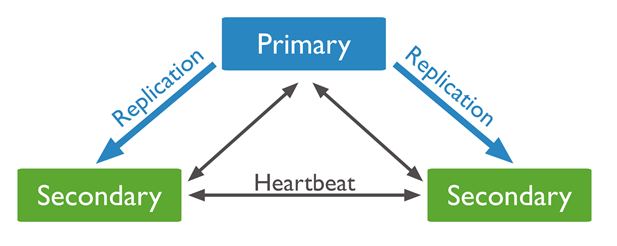

Secondaries replicate the primary's oplog and apply the operations to their data sets asynchronously. By having the secondaries' data sets reflect the primary's data set, the replica set can continue to function despite the failure of one or more members.

When a primary does not communicate with the other members of the set for more than the configured electionTimeoutMillis period (10 seconds by default), an eligible secondary calls for an election to nominate itself as the new primary. The cluster attempts to complete the election of a new primary and resume normal operations.

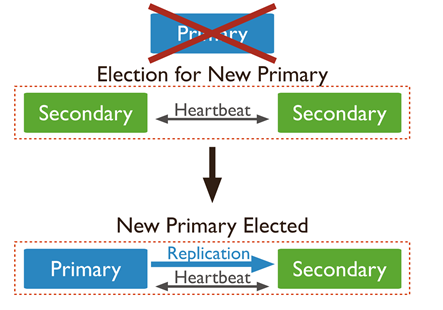

The replica set cannot process write operations until the election completes successfully. The replica set can continue to serve read queries if such queries are configured to run on secondaries while the primary is offline.

By default, clients read from the primary; however, clients can specify a read preference to send read operations to secondaries.

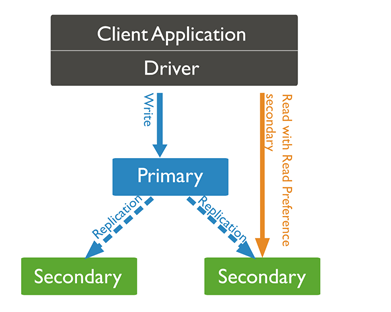

Depending on the read concern, clients can see the results of writes before the writes are durable:

*    Regardless of a write's write concern, other clients using "local" or "available" read concern can see the result of a write operation before the write operation is acknowledged to the issuing client.
*    Clients using "local" or "available" read concern can read data which may be subsequently rolled back during replica set failovers.

## Sharding
See this [link](https://docs.mongodb.com/manual/sharding/)

Sharding is a method for distributing data across multiple machines. MongoDB uses sharding to support deployments with very large data sets and high throughput operations.

Database systems with large data sets or high throughput applications can challenge the capacity of a single server. For example, high query rates can exhaust the CPU capacity of the server. Working set sizes larger than the system's RAM stress the I/O capacity of disk drives.

There are two methods for addressing system growth: vertical and horizontal scaling.

Vertical Scaling involves increasing the capacity of a single server, such as using a more powerful CPU, adding more RAM, or increasing the amount of storage space. Limitations in available technology may restrict a single machine from being sufficiently powerful for a given workload. Additionally, Cloud-based providers have hard ceilings based on available hardware configurations. As a result, there is a practical maximum for vertical scaling.

Horizontal Scaling involves dividing the system dataset and load over multiple servers, adding additional servers to increase capacity as required. While the overall speed or capacity of a single machine may not be high, each machine handles a subset of the overall workload, potentially providing better efficiency than a single high-speed high-capacity server. Expanding the capacity of the deployment only requires adding additional servers as needed, which can be a lower overall cost than high-end hardware for a single machine. The trade off is increased complexity in infrastructure and maintenance for the deployment.

## Sharded cluster

A MongoDB sharded cluster consists of the following components:

*    shard: Each shard contains a subset of the sharded data. Each shard can be deployed as a replica set.
*    mongos: The mongos acts as a query router, providing an interface between client applications and the sharded cluster. 
*    config servers: Config servers store metadata and configuration settings for the cluster.

The following graphic describes the interaction of components within a sharded cluster:

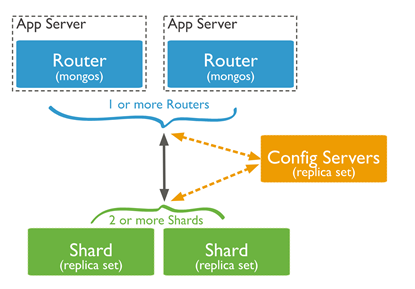

MongoDB shards data at the collection level, distributing the collection data across the shards in the cluster.

### Shard key

MongoDB uses the shard key to distribute the collection's documents across shards. The shard key consists of a field or multiple fields in the documents.

A document's shard key value determines its distribution across the shards. To shard a populated collection, the collection must have an index that starts with the shard key. 

Shard Key Strategy

The choice of shard key affects the performance, efficiency, and scalability of a sharded cluster. A cluster with the best possible hardware and infrastructure can be bottlenecked by the choice of shard key. The choice of shard key and its backing index can also affect the sharding strategy that your cluster can use.

### Hashed Sharding

### What is hashing

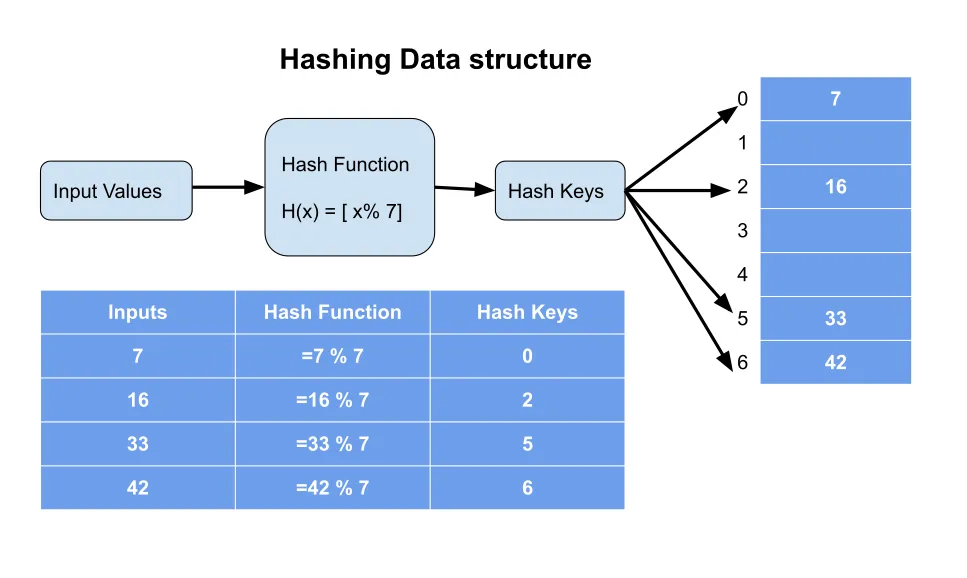



Hashed Sharding involves computing a hash of the shard key field's value. Each chunk is then assigned a range based on the hashed shard key values.

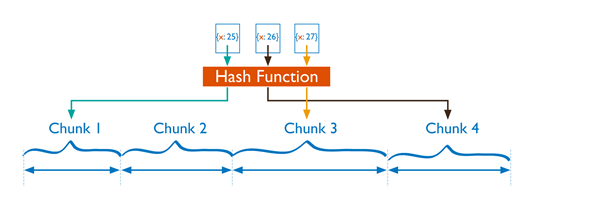

### Ranged Sharding

While a range of shard keys may be "close", their hashed values are unlikely to be on the same chunk. Data distribution based on hashed values facilitates more even data distribution, especially in data sets where the shard key changes monotonically.  

In ranged-based sharding, MongoDB automatically divides data into contiguous ranges determined by the shard key values. In this model, documents with “close” shard key values are likely to be in the same chunk or shard. This allows for efficient queries where reads target documents within a contiguous range. However, both read and write performance may decrease with poor shard key selection. 

However, hashed distribution means that range-based queries on the shard key are less likely to target a single shard, resulting in more cluster wide broadcast operations

A range of shard keys whose hash values are "close" are more likely to reside on the same chunk. This allows for targeted operations as a mongos can route the operations to only the shards that contain the required data.

The efficiency of ranged sharding depends on the shard key chosen. Poorly considered shard keys can result in uneven distribution of data, which can negate some benefits of sharding or can cause performance bottlenecks. See shard key selection for range-based sharding.

### Zones in Sharded Clusters

Zones can help improve the locality of data for sharded clusters that span multiple data centers (say in various cities: one zone per city).

In sharded clusters, you can create zones of sharded data based on the shard key for example one zone of ub_west and ub_east have two separate shards in one Zone. You can associate each zone with one or more shards (ub_east and ub_west: Zone A) in the cluster. A shard can associate with any number of zones. In a balanced cluster, MongoDB migrates chunks covered by a zone only to those shards associated with the zone.

Each zone covers one or more ranges of shard key values. Each range a zone covers is always inclusive of its lower boundary and exclusive of its upper boundary.

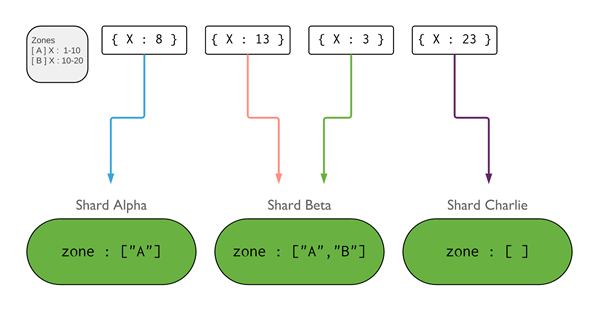

## Sharding and Replica set

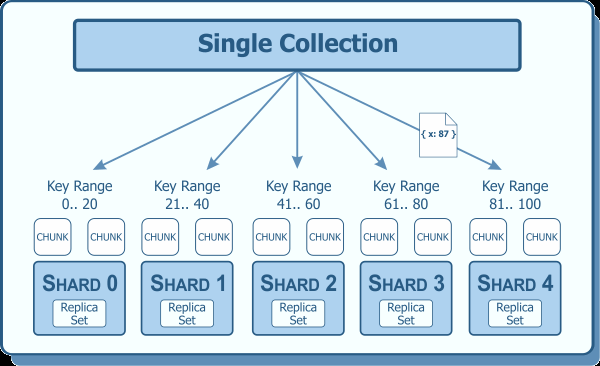

### Advantages of Sharding

**Fast Read/Write opertaions**

MongoDB distributes the read and write workload across the shards in the sharded cluster, allowing each shard to process a subset of cluster operations. Both read and write workloads can be scaled horizontally across the cluster by adding more shards.

For queries that include the shard key or the prefix of a compound shard key, mongos can target the query at a specific shard or set of shards. These targeted operations are generally more efficient than broadcasting to every shard in the cluster.

**Less Storage Capacity per machine**

Sharding distributes data across the shards in the cluster, allowing each shard to contain a subset of the total cluster data. As the data set grows, additional shards increase the storage capacity of the cluster.

**High Availability**

The deployment of config servers and shards as replica sets provide increased availability.  

Even if one or more shard replica sets become completely unavailable, the sharded cluster can continue to perform partial reads and writes. That is, while data on the unavailable shard(s) cannot be accessed, reads or writes directed at the available shards can still succeed.

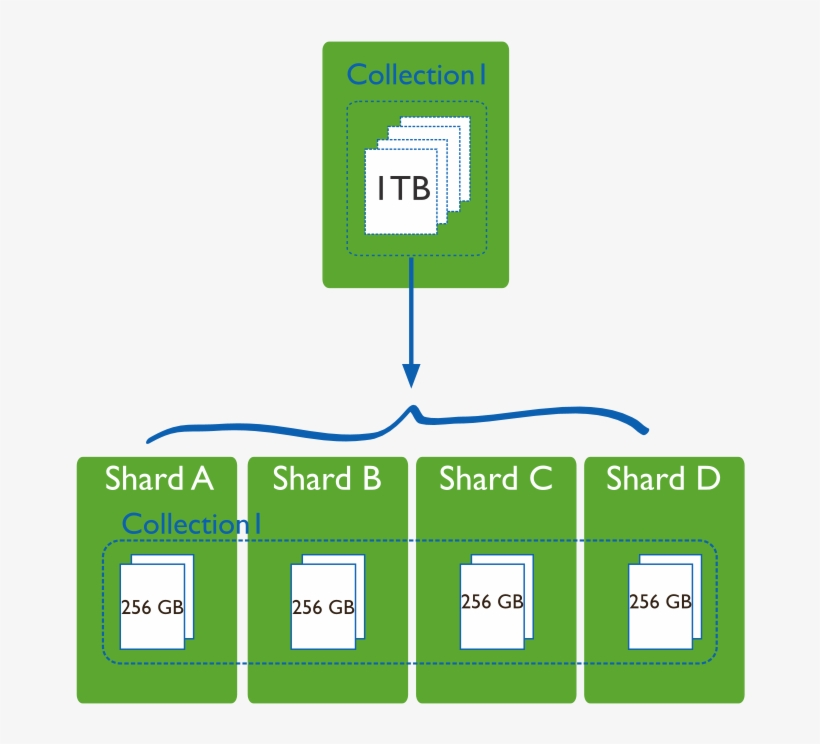

### Sharded and Non-Sharded Collections
A mix per database (NOT collection)

A <b>database</b> can have a mixture of sharded and unsharded collections. Sharded collections are partitioned and distributed across the shards in the cluster. Unsharded collections are stored on a primary shard. Each database has its own primary shard.

### Connecting to a Sharded Cluster

You must connect to a mongos router to interact with any collection in the sharded cluster. This includes sharded and unsharded collections. Clients should never connect to a single shard in order to perform read or write operations.

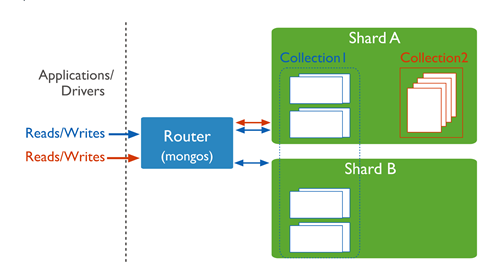

### Chunks

MongoDB partitions sharded data into chunks. Each chunk has an inclusive lower and exclusive upper range based on the shard key.

In [ ]:
########### Done ##############